In [2]:
import yaml
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
from dask.distributed import Client, progress
from datetime import datetime, timedelta
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from scipy import stats
import numpy.ma as ma
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import seaborn as sns
# %matplotlib inline

In [3]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [4]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
ar_dict = config[ssn]

In [12]:

def mjo_index(ref, start_date, end_date):
    '''create a pandas df of the Madden Julian Oscillation index 
    on daily, monthly, or seasonal timescale 
    with yes MJO phase as positive, no MJO phase as negative
    '''
    fname_daily = path_to_data + 'teleconnection_indices/mjo.events.ouu.1979.2019.txt'
    df = pd.read_csv(fname_daily, delim_whitespace=True, engine='python')
    df['date'] = pd.date_range('1979-01-01 9:00:00', '2019-12-31 9:00:00', freq='1D')
    df = df.set_index('date')
    
    if ref == 'daily':
        # (yes MJO) positive = 1, (no MJO) negative = -1
        df['COND'] = 0
        idx = (df['PHA']>0) & (df['AMPLITUDE']>1)
        df.loc[idx, 'COND'] = 1
        df.loc[df['PHA']==0, 'COND'] = -1

    elif ref == 'monthly':
        print('No monthly capabilities yet')
        
    elif ref == 'seasonal':
        print('No seasonal capabilities yet')
    
    # trim to start_date, end_date
    idx = (df.index >= start_date) & (df.index <= end_date + " 23:59:59")
    df = df.loc[idx]
        
    return df

def ar_daily_df(ssn, nk):
    out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
    filepath = out_path + 'AR-types_ALLDAYS.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
        
    # get total of all AR types
    df_cat['AR_ALL'] = df_cat['AR_CAT1'] + df_cat['AR_CAT2'] + df_cat['AR_CAT3']
    df_cat['AR_CAT'] = df['AR_CAT']
    
    return df_cat

In [10]:
df = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])

# Select DJFMAM months
if ar_dict['mon_s'] > ar_dict['mon_e']:
    idx = (df.MON >= ar_dict['mon_s']) | (df.MON <= ar_dict['mon_e'])
else:
    idx = (df.MON >= ar_dict['mon_s']) & (df.MON <= ar_dict['mon_e'])

df = df.loc[idx]


df

,DAY,MON,YEAR,AMPLITUDE,PC1,PC2,PHA,DUR,TAG,TYPE,COND
date,,,,,,,,,,,
1979-12-01 09:00:00,1,12,1979,1.506855,1.470681,-0.328180,4,57,7,2,1
1979-12-02 09:00:00,2,12,1979,1.522152,1.510941,-0.184387,4,57,7,2,1
1979-12-03 09:00:00,3,12,1979,1.508569,1.508386,-0.023360,4,57,7,2,1
1979-12-04 09:00:00,4,12,1979,1.468868,1.460975,0.152049,5,57,7,2,1
1979-12-05 09:00:00,5,12,1979,1.409522,1.368360,0.338136,5,57,7,2,1
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,27,5,2019,1.903655,-1.052331,-1.586346,2,46,191,2,1
2019-05-28 09:00:00,28,5,2019,1.837017,-0.907316,-1.597311,2,46,191,2,1
2019-05-29 09:00:00,29,5,2019,1.742527,-0.752355,-1.571736,2,46,191,2,1


In [15]:
df_djfmam = ar_daily_df(ssn='djfmam', nk=3)
new_df = df_djfmam.join(df)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,DAY,MON,YEAR,AMPLITUDE,PC1,PC2,PHA,DUR,TAG,TYPE,COND
date,,,,,,,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,12,1979,1.506855,1.470681,-0.328180,4,57,7,2,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,2,12,1979,1.522152,1.510941,-0.184387,4,57,7,2,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,3,12,1979,1.508569,1.508386,-0.023360,4,57,7,2,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,4,12,1979,1.468868,1.460975,0.152049,5,57,7,2,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,5,12,1979,1.409522,1.368360,0.338136,5,57,7,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,27,5,2019,1.903655,-1.052331,-1.586346,2,46,191,2,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,28,5,2019,1.837017,-0.907316,-1.597311,2,46,191,2,1
2019-05-29 09:00:00,0.0,0.0,0.0,0.0,0,29,5,2019,1.742527,-0.752355,-1.571736,2,46,191,2,1


In [16]:
# construct lists - to create df later
lst1 = []
lst2 = []
lst3 = []
lst4 = []
lst5 = []

for i in range(9):
    # count total number of days in each phase
    idx = (new_df['PHA'] == i) 
    p_len = len(new_df.loc[idx])
    
    # loop through AR Cat
    for j in range(3):
        # count number of each ARCAT that are also MJO phase
        idx = (new_df['PHA'] == i) & (new_df['AR_CAT'] == j+1)
        arcat_mjo = len(new_df.loc[idx])
        
        lst1.append(i)
        lst2.append(j+1)
        lst3.append(p_len)
        lst4.append(arcat_mjo)
        lst5.append((arcat_mjo/p_len)*100)
        
# # convert lists to dataframe
dfObj = pd.DataFrame(list(zip(lst1, lst2, lst3, lst4, lst5)), columns =['PHA' , 'ARCAT', 'MJO_len', 'FREQ', 'percFREQ']) 
dfObj

,PHA,ARCAT,MJO_len,FREQ,percFREQ
0,0,1,2509,86,3.427660
1,0,2,2509,75,2.989239
2,0,3,2509,106,4.224791
3,1,1,505,9,1.782178
4,1,2,505,18,3.564356
5,1,3,505,29,5.742574
6,2,1,640,15,2.343750
7,2,2,640,27,4.218750
8,2,3,640,28,4.375000
9,3,1,617,22,3.565640


/home/nash/DATA/repositories/AR_types/figs/MJO_barplot_djfmam.png


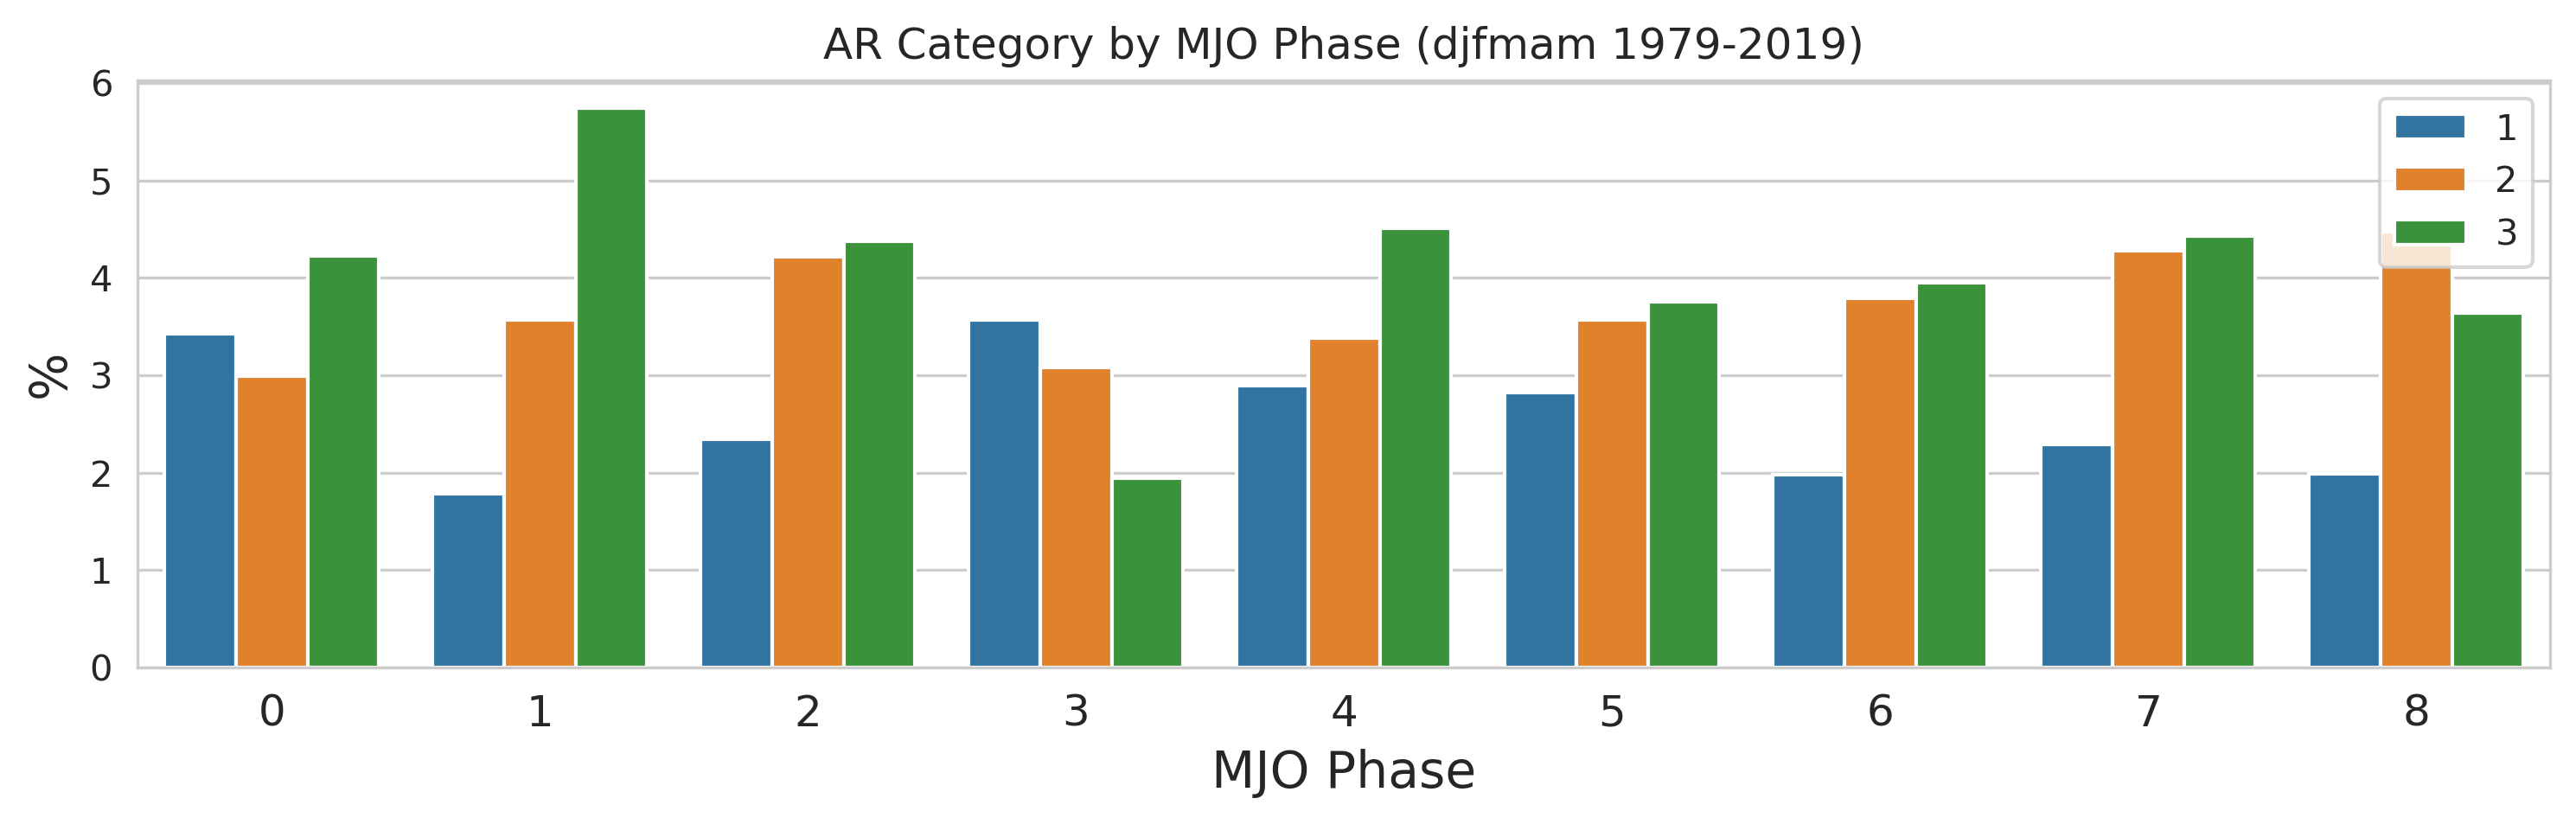

<Figure size 3600x900 with 0 Axes>

In [18]:
fname = path_to_figs + 'MJO_barplot_' + ssn
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((12.0,3.0))
fig.dpi = 300
nplots=1

flatui = ["gold","lightcoral", "rebeccapurple"]
columns= np.arange(0, 9, 1)
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    sns.barplot(x='PHA', y='percFREQ', hue='ARCAT', data=dfObj)
    ax.set_ylabel('%', fontsize=14)
    ax.set_title('AR Category by MJO Phase ({0} 1979-2019)'.format(ssn), fontsize=12)
    ax.set_xlabel('MJO Phase', fontsize=14)
    ax.set_xticklabels(columns, fontsize=12)
    ax.legend(loc='upper right')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [19]:
# construct lists - to create df later
lst1 = []
lst2 = []
lst3 = []
lst4 = []
lst5 = []

for i in range(2):
    # count total number of days with no phase (PHA=0) and some MJO phase (PHA>0)
    if i == 0:
        idx = (new_df['PHA'] <= i)
    if i > 0:
        idx = (new_df['PHA'] >= i)
    
    p_len = len(new_df.loc[idx])
    
    # loop through AR Cat
    for j in range(3):
        # count number of each ARCAT that are also MJO phase
        if i == 0:
            idx = (new_df['PHA'] == i) & (new_df['AR_CAT'] == j+1)
        if i > 0:
            idx = (new_df['PHA'] >= i) & (new_df['AR_CAT'] == j+1)
        
        arcat_mjo = len(new_df.loc[idx])
        
        lst1.append(i)
        lst2.append(j+1)
        lst3.append(p_len)
        lst4.append(arcat_mjo)
        lst5.append((arcat_mjo/p_len)*100)
        
# # convert lists to dataframe
dfObj2 = pd.DataFrame(list(zip(lst1, lst2, lst3, lst4, lst5)), columns =['PHA' , 'ARCAT', 'MJO_len', 'FREQ', 'percFREQ']) 
dfObj2

,PHA,ARCAT,MJO_len,FREQ,percFREQ
0,0,1,2509,86,3.427660
1,0,2,2509,75,2.989239
2,0,3,2509,106,4.224791
3,1,1,4781,118,2.468103
4,1,2,4781,182,3.806735
5,1,3,4781,192,4.015896


/home/nash/DATA/repositories/AR_types/figs/MJO_barplot_binary_djfmam.png


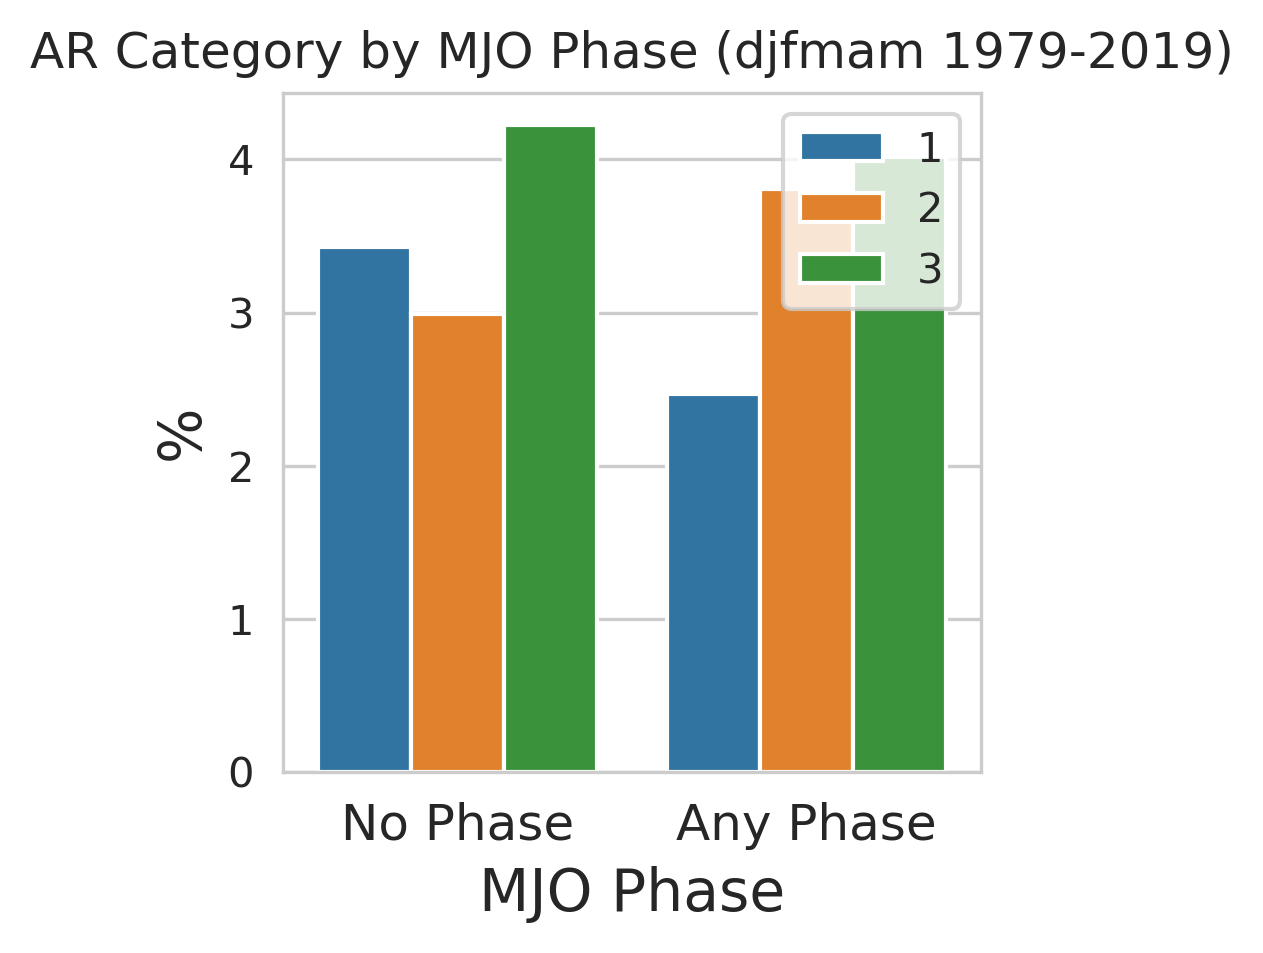

<Figure size 900x900 with 0 Axes>

In [20]:
fname = path_to_figs + 'MJO_barplot_binary_' + ssn
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((3.0,3.0))
fig.dpi = 300
nplots=1

flatui = ["gold","lightcoral", "rebeccapurple"]
columns= ['No Phase', 'Any Phase']
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    sns.barplot(x='PHA', y='percFREQ', hue='ARCAT', data=dfObj2)
    ax.set_ylabel('%', fontsize=14)
    ax.set_title('AR Category by MJO Phase ({0} 1979-2019)'.format(ssn), fontsize=12)
    ax.set_xlabel('MJO Phase', fontsize=14)
    ax.set_xticklabels(columns, fontsize=12)
    ax.legend(loc='upper right')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [34]:
def diff_proportion_zstat_mjo(df):    
    AR_CATS = ('AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'AR_ALL')
    TELE = ['PHA']
    zstat_array = []
    pval_array = []
    
    
    for i, tele in enumerate(TELE):
        
        s_positive = df.loc[(df[tele] > 0)]
        s_negative = df.loc[(df[tele] == 0)]

        for j, ar_type in enumerate(AR_CATS):
            zstat, pval = test_diff_proportion(s_positive[ar_type].values, s_negative[ar_type].values)
        
            zstat_array.append((zstat))
            pval_array.append((pval))
        
            zstat_final = zstat_array 
            pval_final = pval_array
    
    return zstat_final, pval_final

In [35]:
z, p = diff_proportion_zstat_mjo(new_df)
    
arrays = [['MJO']*4,
           ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'AR_ALL']]
index = pd.MultiIndex.from_arrays(arrays, names=('Teleconnection', 'AR Type'))
df_z = pd.DataFrame({'zstat': z,
                    'pval': p},
                   index=index)

In [36]:
df_z

zstat      pval
Teleconnection AR Type                    
MJO            AR_CAT1 -2.360091  0.018270
               AR_CAT2  1.798135  0.072156
               AR_CAT3 -0.427949  0.668689
               AR_ALL  -0.466139  0.641116